In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import confusion_matrix
#from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, auc,precision_score,recall_score

import warnings
warnings.filterwarnings("ignore")

In [12]:
RANDOM_SEED = 42

In [13]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(1))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(1))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N


In [14]:
df_train['Train'] = 1 # помечаем где у нас трейн
df_test['Train'] = 0 # помечаем где у нас тест

df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем

In [15]:
#Посмотрим на структуру объединенного датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Описания полей датасета

* client_id - идентификатор клиента
* education - уровень образования
* sex - пол заемщика
* age - возраст заемщика
* car - флаг наличия автомобиля
* car_type - флаг автомобиля иномарки
* decline_app_cnt - количество отказанных прошлых заявок
* good_work - флаг наличия “хорошей” работы
* bki_request_cnt - количество запросов в БКИ
* home_address - категоризатор домашнего адреса
* work_address - категоризатор рабочего адреса
* income - доход заемщика
* foreign_passport - наличие загранпаспорта
* sna - связь заемщика с клиентами банка
* first_time - давность наличия информации о заемщике
* score_bki - скоринговый балл по данным из БКИ
* region_rating - рейтинг региона
* app_date - дата подачи заявки
* default - флаг дефолта по кредиту

тут что то не получилось с форматированием

In [16]:
#Посмотрим в каких колонках есть незаполненные значения
df.columns[df.isna().any()].tolist()

['education', 'default']

In [17]:
#Заполним колонку education MOD(ой)
df['education'] = df['education'].fillna(df['education'].mode()[0])

In [18]:
#Создадим списки колонок по типам 
#временные переменные
date_cols = ['app_date']
# бинарные переменные (default не включаем в список, посольку это наша целевая колонка)
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
# категориальные переменные  (Train не включаем в список, это наш добавленныей признак, который не будет участвовать в обработке)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, client_id не включаем
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt','score_bki', 'income']

In [19]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

In [20]:
# Отображение информации о колонке
def show_info_column(dataframe, column):
    display(dataframe[column].describe())
    plt.hist(dataframe[column], bins=30)
    plt.ylabel('Количество')
    plt.xlabel(column)
    # plt.title('Histogram');
    plt.show()
    # Нижняя граница выбросов
    minimum_emission_limit = round(
        dataframe[column].mean() - 3 * dataframe[column].std(), 0)
    # Верхняя граница выбросов
    maximum_emission_limit = round(
        dataframe[column].mean() + 3 * dataframe[column].std(), 0)
    # Количество выбросов
    quantity_of_emissions = len(dataframe[round(
        ((df[column] - dataframe[column].mean()) / dataframe[column].std()).abs(), 0) > 3].index)
    print('Границы выбросов', minimum_emission_limit, maximum_emission_limit)
    display(sns.boxplot(data=dataframe[column]))
    print('Количество выбросов', quantity_of_emissions)

In [21]:
def show_logarifm(dataframe,column):
    plt.figure()
    sns.distplot(np.log1p(dataframe[column][dataframe['Train']==1]), kde = False, rug=False)    
    plt.title(column)
    plt.show()    

In [22]:
def show_confusion_matrix(y_true, y_pred):
    """Функция отображает confusion-матрицу"""
    color_text = plt.get_cmap('GnBu')(1.0)
    class_names = ['Дефолт', 'НЕ дефолт']
    cm = confusion_matrix(y_true, y_pred)
    cm[0,0], cm[1,1] = cm[1,1], cm[0,0]
    df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), title="Матрица ошибок")
    ax.title.set_fontsize(15)
    sns.heatmap(df, square=True, annot=True, fmt="d", linewidths=1, cmap="GnBu")
    plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor", fontsize=12)
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor", fontsize=12)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color = color_text)
    ax.set_xlabel('Реальные значения', fontsize=14, color = color_text)
    b, t = plt.ylim()
    plt.ylim(b+0.5, t-0.5)
    fig.tight_layout()
    plt.show()

In [23]:
def all_metrics(y_true, y_pred, y_pred_prob):
    """Функция выводит в виде датафрейма значения основных метрик классификации"""
    dict_metric = {}
    P = np.sum(y_true==1)
    N = np.sum(y_true==0)
    TP = np.sum((y_true==1)&(y_pred==1))
    TN = np.sum((y_true==0)&(y_pred==0))
    FP = np.sum((y_true==0)&(y_pred==1))
    FN = np.sum((y_true==1)&(y_pred==0))
    
    dict_metric['P'] = [P,'Дефолт']
    dict_metric['N'] = [N,'БЕЗ дефолта']
    dict_metric['TP'] = [TP,'Истинно дефолтные']
    dict_metric['TN'] = [TN,'Истинно НЕ дефолтные']
    dict_metric['FP'] = [FP,'Ложно дефолтные']
    dict_metric['FN'] = [FN,'Ложно НЕ дефолтные']
    dict_metric['Accuracy'] = [accuracy_score(y_true, y_pred),'Accuracy=(TP+TN)/(P+N)']
    dict_metric['Precision'] = [precision_score(y_true, y_pred),'Точность = TP/(TP+FP)'] 
    dict_metric['Recall'] = [recall_score(y_true, y_pred),'Полнота = TP/P']
    dict_metric['F1-score'] = [f1_score(y_true, y_pred),'Среднее гармоническое Precision и Recall']
    dict_metric['ROC_AUC'] = [roc_auc_score(y_true, y_pred_prob),'ROC-AUC']    

    temp_df = pd.DataFrame.from_dict(dict_metric, orient='index', columns=['Значение', 'Описание метрики'])
    display(temp_df) 

In [24]:
def show_roc_curve(y_true, y_pred_prob):
    """Функция отображает ROC-кривую"""
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    plt.figure()
    plt.plot([0, 1], label='Случайный классификатор', linestyle='--')
    plt.plot(fpr, tpr, label = 'Логистическая регрессия')
    plt.title('Логистическая регрессия ROC AUC = %0.3f' % roc_auc_score(y_true, y_pred_prob))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

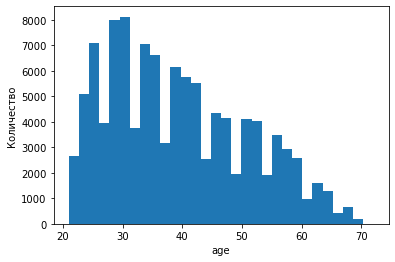

Границы выбросов 5.0 74.0


<AxesSubplot:>

Количество выбросов 0


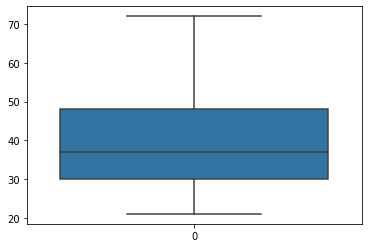

In [25]:
show_info_column(df,'age')

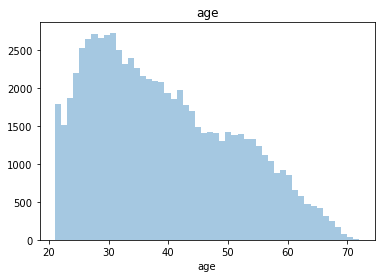

In [26]:
plt.figure()
sns.distplot(df['age'][df['Train']==1], kde = False, rug=False)    
plt.title('age')
plt.show()

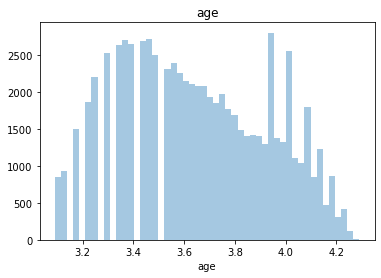

In [27]:
plt.figure()
sns.distplot(np.log1p(df['age'][df['Train']==1]), kde = False, rug=False)    
plt.title('age')
plt.show()

In [28]:
#После логорифмирование выгляднет лучше, берем логарифм от признака  
df['age'] = np.log1p(df['age'])

count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64

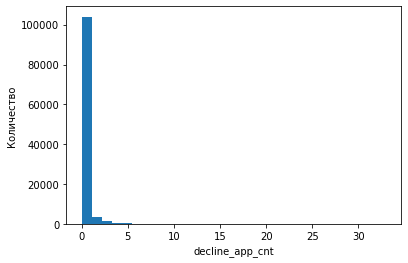

Границы выбросов -2.0 3.0


<AxesSubplot:>

Количество выбросов 1190


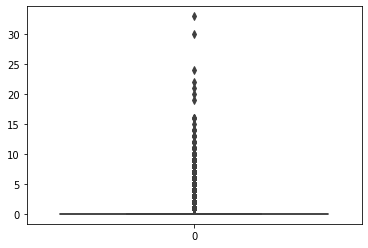

In [29]:
show_info_column(df,'decline_app_cnt')

In [30]:
df_copy=df.copy()
df_copy['decline_app_cnt'] = np.log1p(df_copy['decline_app_cnt'])

count    110148.000000
mean          0.151330
std           0.361331
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.526361
Name: decline_app_cnt, dtype: float64

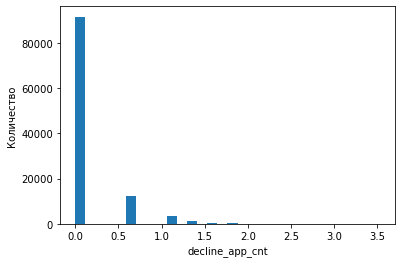

Границы выбросов -1.0 1.0


<AxesSubplot:>

Количество выбросов 6177


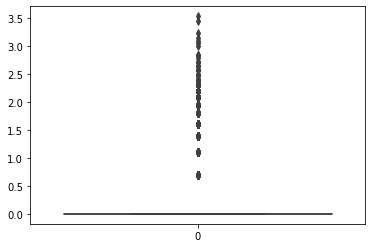

In [31]:
show_info_column(df_copy,'decline_app_cnt')

In [32]:
#По прежнему очень много выбросов, возьмем логарифм , а выбросы пока оставим как есть 
df['decline_app_cnt'] = np.log1p(df['decline_app_cnt'])

count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64

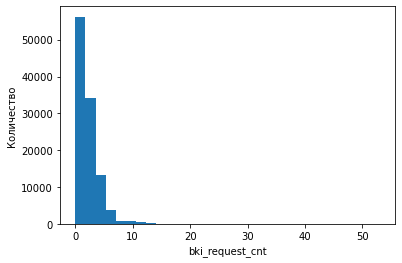

Границы выбросов -5.0 9.0


<AxesSubplot:>

Количество выбросов 1442


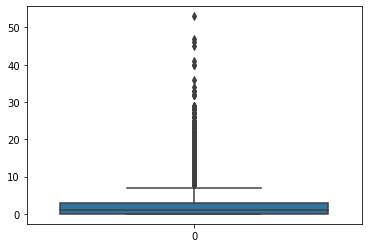

In [33]:
show_info_column(df,'bki_request_cnt')

count    110148.000000
mean          0.878752
std           0.658667
min           0.000000
25%           0.000000
50%           0.693147
75%           1.386294
max           3.988984
Name: bki_request_cnt, dtype: float64

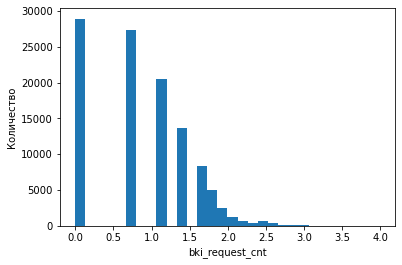

Границы выбросов -1.0 3.0


<AxesSubplot:>

Количество выбросов 19794


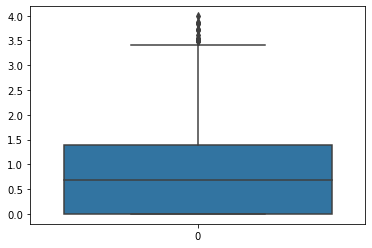

In [34]:
df_copy=df.copy()
df_copy['bki_request_cnt'] = np.log1p(df_copy['bki_request_cnt'])
show_info_column(df_copy,'bki_request_cnt')

In [35]:
#График выглядет лучше , но выбросов стало очень много, возьмем пока логарфим от признака и выбросы оставим
df['bki_request_cnt'] = np.log1p(df['bki_request_cnt'])

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

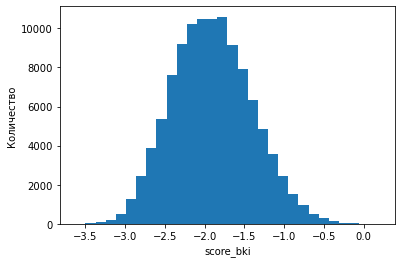

Границы выбросов -3.0 -0.0


<AxesSubplot:>

Количество выбросов 38


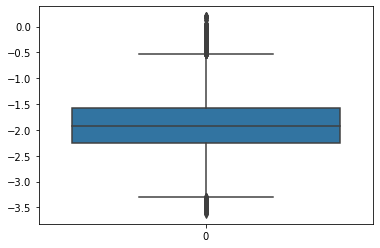

In [36]:
show_info_column(df,'score_bki')

Здесь мы видим нормальное распреление, небольшое количество выбросов , поэтому оставляем все как есть 

count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64

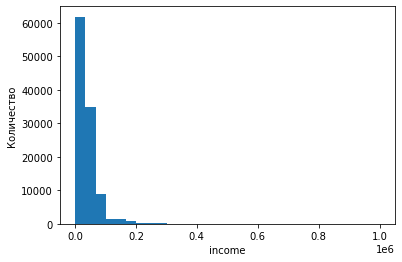

Границы выбросов -95187.0 177212.0


<AxesSubplot:>

Количество выбросов 1553


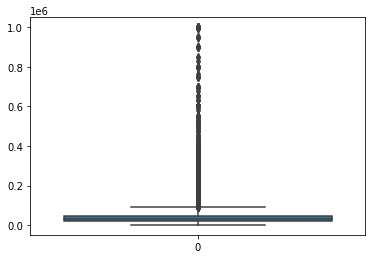

In [37]:
show_info_column(df,'income')

count    110148.000000
mean         10.345792
std           0.696636
min           6.908755
25%           9.903538
50%          10.308986
75%          10.778977
max          13.815512
Name: income, dtype: float64

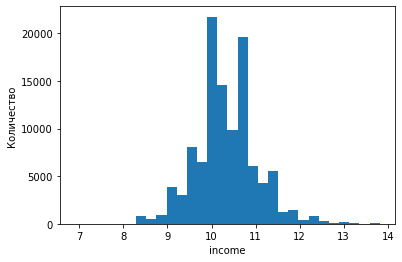

Границы выбросов 8.0 12.0


<AxesSubplot:>

Количество выбросов 110148


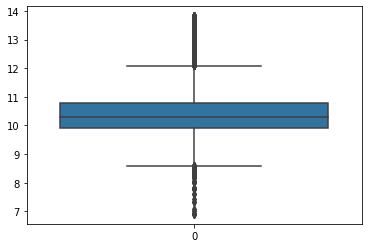

In [38]:
df_copy=df.copy()
df_copy['income'] = np.log1p(df_copy['income'])
show_info_column(df_copy,'income')

In [39]:
#График стал лучше, берем логарифм от признака
df['income'] = np.log1p(df['income'])

<AxesSubplot:>

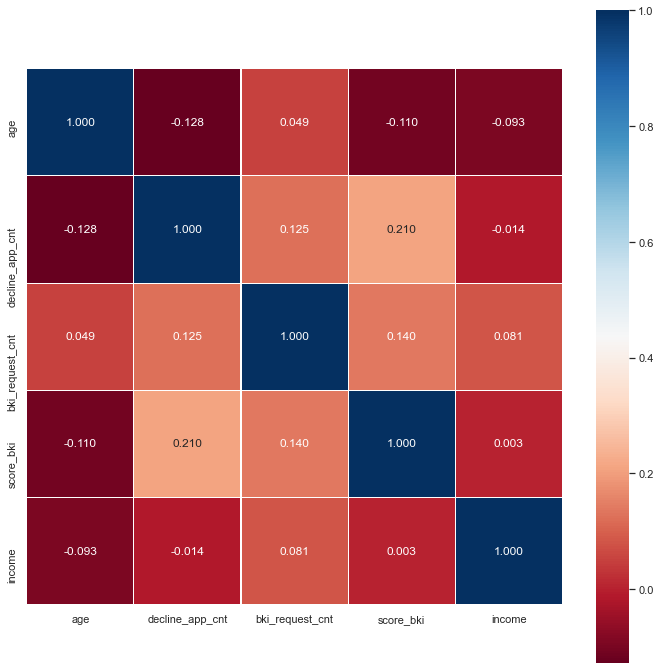

In [40]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(df[num_cols][df['Train']==1].corr(), square=True,
              annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu")

Мультиколлинеарности не обнаружено, оставляем все признаки

<AxesSubplot:>

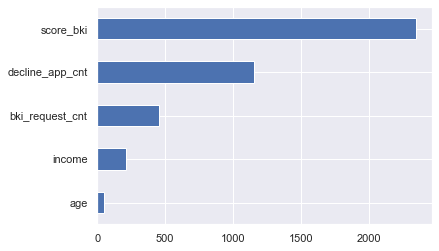

In [41]:
temp_df = df[df['Train']==1]
imp_num = Series(f_classif(temp_df[num_cols], temp_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [42]:
df['education'].value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [43]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
edu_label_encoder = LabelEncoder()
df['education'] = edu_label_encoder.fit_transform(df['education'])

# убедимся в преобразовании    
df.head(10)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train
0,25905,01FEB2014,3,1,4.143135,1,1,0.000000,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0.0,1
1,63161,12MAR2014,3,0,4.094345,0,0,0.000000,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0.0,1
2,25887,01FEB2014,3,1,3.258097,1,0,1.098612,0,-1.408142,0.693147,80,1,2,10.308986,1,4,1,0.0,1
3,16222,23JAN2014,3,0,3.988984,0,0,0.000000,0,-2.057471,1.098612,50,2,3,9.210440,1,3,0,0.0,1
4,101655,18APR2014,1,1,3.891820,0,0,0.000000,1,-1.244723,0.693147,60,2,3,10.308986,1,4,1,0.0,1
5,41415,18FEB2014,3,1,3.332205,1,0,0.000000,1,-2.032257,0.000000,50,1,1,9.615872,2,3,0,0.0,1
6,28436,04FEB2014,3,1,3.688879,0,0,0.000000,0,-2.225004,0.000000,60,1,2,10.239996,1,1,0,0.0,1
7,68769,17MAR2014,3,0,3.688879,0,0,0.000000,0,-1.522739,0.693147,50,2,3,10.714440,3,3,0,0.0,1
8,38424,14FEB2014,3,0,3.931826,1,0,0.693147,0,-1.676061,0.000000,50,1,1,10.308986,1,4,0,0.0,1
9,4496,10JAN2014,4,0,4.007333,0,0,0.000000,0,-2.695176,0.693147,50,2,3,10.085851,1,3,0,0.0,1


<AxesSubplot:>

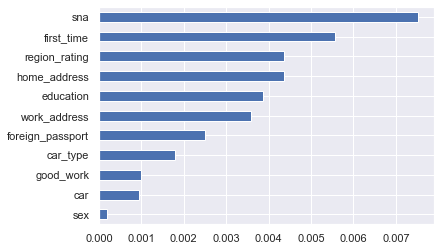

In [44]:
temp_df = df[df['Train']==1]
imp_cat = Series(mutual_info_classif(temp_df[bin_cols + cat_cols], temp_df['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самым значимым признаком по Mutual information тесту является связь заемщика с клиентами банка (sna) и давность наличия информации о заемщике (first_time), потом идет рейтинг региона (region_rating) и в конце пол (sex).

In [45]:
df.drop(['app_date','client_id'], axis=1, inplace=True)

In [46]:
#Преобразуем категориальные признаки
df=pd.get_dummies(df, prefix=cat_cols, columns=cat_cols)

In [47]:
#Стандартизация пока пропустим
#X_num_train = StandardScaler().fit_transform(df[df['Train']==1][num_cols].values)
#Y_num_train = StandardScaler().fit_transform(df[df['Train']==0][num_cols].values)

In [48]:
train_data = df.query('Train == 1').drop(['Train'], axis=1)
test_data = df.query('Train == 0').drop(['Train'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)

In [49]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [50]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 37), (73799, 37), (73799, 36), (59039, 36), (14760, 36))

,Значение,Описание метрики
P,1827.000000,Дефолт
N,12933.000000,БЕЗ дефолта
TP,41.000000,Истинно дефолтные
TN,12882.000000,Истинно НЕ дефолтные
FP,51.000000,Ложно дефолтные
FN,1786.000000,Ложно НЕ дефолтные
Accuracy,0.875542,Accuracy=(TP+TN)/(P+N)
Precision,0.445652,Точность = TP/(TP+FP)
Recall,0.022441,Полнота = TP/P
F1-score,0.042731,Среднее гармоническое Precision и Recall


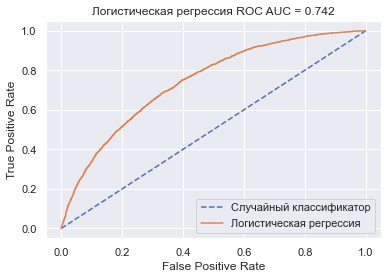

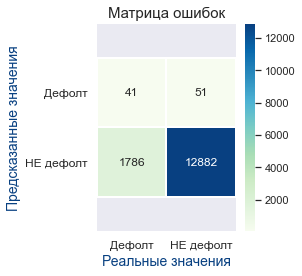

In [51]:
model = LogisticRegression()
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]

y_pred = model.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, probs)
show_roc_curve(y_test, probs)
show_confusion_matrix(y_test, y_pred)

In [52]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=RANDOM_SEED)
iter_ = 50
epsilon_stop = 1e-3
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test, preds))
print('Precision: %.4f' % precision_score(y_test, preds))
print('Recall: %.4f' % recall_score(y_test, preds))
print('F1: %.4f' % f1_score(y_test, preds))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'sag'
	tol: 0.001
	verbose: 0
	warm_start: False
Accuracy: 0.6660
Precision: 0.2238
Recall: 0.6880
F1: 0.3377


,Значение,Описание метрики
P,1827.000000,Дефолт
N,12933.000000,БЕЗ дефолта
TP,1257.000000,Истинно дефолтные
TN,8573.000000,Истинно НЕ дефолтные
FP,4360.000000,Ложно дефолтные
FN,570.000000,Ложно НЕ дефолтные
Accuracy,0.665989,Accuracy=(TP+TN)/(P+N)
Precision,0.223785,Точность = TP/(TP+FP)
Recall,0.688013,Полнота = TP/P
F1-score,0.337722,Среднее гармоническое Precision и Recall


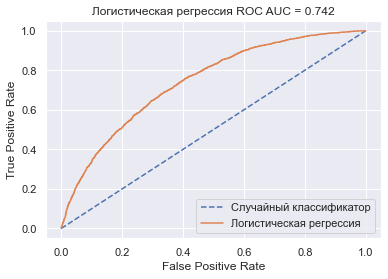

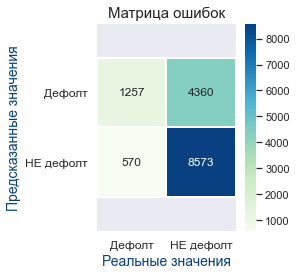

In [53]:
model = LogisticRegression(
    random_state=RANDOM_SEED, 
    C=1.0,
	class_weight= 'balanced',
	dual= False,
	fit_intercept= True,
	intercept_scaling= 1,
	l1_ratio= None,
	max_iter= 50,
	multi_class= 'auto',
	n_jobs= None,
	penalty= 'none',
	solver= 'sag',
	tol= 0.001,
	verbose= 0,
	warm_start= False)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]
y_pred = model.predict(X_test)

# Оценка качества модели
all_metrics(y_test, y_pred, probs)
show_roc_curve(y_test, probs)
show_confusion_matrix(y_test, y_pred)

Как мы видим метрики стали значительно лучше чем у первой модели с параметрами по умолчанию

Submission

In [54]:
train_data = df.query('Train == 1').drop(['Train'], axis=1)
test_data = df.query('Train == 0').drop(['Train'], axis=1)

In [55]:
X_train=train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [56]:
# проверяем
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 37), (73799, 37), (73799, 36), (73799,), (36349, 36))

In [57]:
model = LogisticRegression(
    random_state=RANDOM_SEED, 
    C=1.0,
	class_weight= 'balanced',
	dual= False,
	fit_intercept= True,
	intercept_scaling= 1,
	l1_ratio= None,
	max_iter= 50,
	multi_class= 'auto',
	n_jobs= None,
	penalty= 'none',
	solver= 'sag',
	tol= 0.001,
	verbose= 0,
	warm_start= False)

model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=50, penalty='none',
                   random_state=42, solver='sag', tol=0.001)

In [58]:
y_pred_prob = model.predict_proba(X_test)[:,1]


submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)